In [1]:
!pip install -q flwr["simulation"] tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.1/330.1 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 MB 7.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.15.0 requires protobuf<4.21,>=3.20.3; python_version < "3.11", but you have protobuf 4.25.3 which is incompatible.


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from google.colab import drive
import flwr as fl
from keras.models import load_model, Sequential
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import classification_report
import keras
from keras.layers import Dense
import seaborn as sns
from functools import partial
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from typing import Dict, Tuple


In [3]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/data/Prepared/cic-iot-2023-updated.csv')

In [5]:
data.drop(columns='Unnamed: 0', inplace=True)
data

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,...,TCP,UDP,ARP,ICMP,IPv,LLC,Tot sum,Tot size,IAT,label
0,0.058119,45775.0,17.00,64.00,15751.092885,15751.092885,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,525.00,50.00,8.310224e+07,1
1,0.163528,307054.5,16.66,62.72,5495.021216,5495.021216,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,5747.84,544.12,8.378485e+07,1
2,0.035925,57.9,6.00,64.00,1.053108,1.053108,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,567.80,54.20,8.307590e+07,1
3,0.057972,32777.0,17.00,64.00,11023.574801,11023.574801,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,525.00,50.00,8.310633e+07,1
4,35.910337,27837.3,6.00,115.80,69.272535,69.272535,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,5926.50,1063.20,2.455997e-03,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1177093,77.484036,853.3,8.80,83.70,13.152179,13.152179,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,1983.60,156.60,1.665172e+08,0
1177094,15.082374,1390970.4,6.00,198.40,86.491632,86.491632,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,797.40,355.60,2.140188e-03,0
1177095,30.180086,35568.6,7.10,132.00,8.743544,8.743544,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,526.80,95.70,2.274399e-02,0
1177096,31.893272,597766.1,8.20,80.60,32.563963,32.563963,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,3340.50,685.90,5.189991e-03,0


In [6]:
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values
print(X.shape)
print(y.shape)

(1177098, 33)
(1177098,)


In [7]:
X_, X_test,y_, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

scalar = StandardScaler()
scalar.fit(X_test)
X_scaled = scalar.fit_transform(X_)
X_test_scaled = scalar.transform(X_test)

In [ ]:
# Split data using Dirichlet distribution
def split_data_dirichlet(X, y, num_clients, alpha):
    labels = np.unique(y)
    client_data = {i: [] for i in range(num_clients)}

    for label in labels:
        label_indices = np.where(y == label)[0]
        np.random.shuffle(label_indices)
        proportions = np.random.dirichlet([alpha] * num_clients)
        proportions = np.cumsum(proportions)[:-1]
        client_splits = np.split(label_indices, (proportions * len(label_indices)).astype(int))

        for client_id, indices in enumerate(client_splits):
            client_data[client_id].extend(indices)

    return client_data

num_clients = 3
alpha = 0.2

client_data_indices = split_data_dirichlet(X_scaled, y_, num_clients, alpha)


In [ ]:
print(client_data_indices)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
client_data_split = {}
for client_id, indices in client_data_indices.items():
    X_client = X_scaled[indices]
    y_client = y_[indices]
    client_data_split[client_id] = (X_client, y_client)

# Ensure client IDs are correct
for client_id, (X_client, y_client) in client_data_split.items():
    print(f"Client {client_id+1} has {len(X_client)} samples")

# Split individual client data into train, val, and test sets
def split_individual_train_sets(client_data, train_split=0.9,):
    X_trains_split, y_trains_split = {}, {}
    X_vals_split, y_vals_split = {}, {}

    for client_id, (X, y) in client_data.items():
        num_data = X.shape[0]
        train_end_idx = int(train_split * num_data)

        X_trains_split[client_id] = X[:train_end_idx]
        y_trains_split[client_id] = y[:train_end_idx]

        X_vals_split[client_id] = X[train_end_idx:]
        y_vals_split[client_id] = y[train_end_idx:]
    return X_trains_split, y_trains_split, X_vals_split, y_vals_split

X_trains_split, y_trains_split, X_vals_split, y_vals_split = split_individual_train_sets(client_data_split)


Client 1 has 246952 samples
Client 2 has 665248 samples
Client 3 has 206043 samples


In [ ]:
# Define FlowerClient class
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, model, X_train, y_train, X_val, y_val):
        self.model = model
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val


    def get_parameters(self, config):
        return self.model.get_weights()

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        self.model.fit(self.X_train, self.y_train, epochs=4, batch_size=512, validation_split=0.1, verbose=0)
        return self.model.get_weights(), len(self.X_train), {}

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        loss, accuracy = self.model.evaluate(self.X_val, self.y_val, verbose=0)
        # Generate predictions
        y_pred = self.model.predict(self.X_val,verbose=0)
        y_pred = (y_pred > 0.5)

        # Compute classification report
        class_report = classification_report(self.y_val, y_pred, digits=5, zero_division=0)

        return loss, len(self.X_val), {"loss": loss, "accuracy": accuracy, "classification_report": class_report}



In [ ]:
def get_model():
  model = Sequential()
  model.add(tf.keras.layers.Input(shape=(33,)),)
  model.add(Dense(4, activation='relu'),)
  model.add(Dense(4, activation='relu'),)
  model.add(Dense(1, activation='sigmoid'),)
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss="binary_crossentropy", metrics=['accuracy'])
  return model

In [ ]:
def create_client(cid, X_trains, y_trains, X_vals, y_vals) -> fl.client.Client:
    model = get_model()
    cid = int(cid)  # Ensure client ID is an integer
    return FlowerClient(model, X_trains[cid], y_trains[cid], X_vals[cid], y_vals[cid]).to_client()

client_fnc = partial(
    create_client,
    X_trains=X_trains_split,
    y_trains=y_trains_split,
    X_vals=X_vals_split,
    y_vals=y_vals_split,
)

def weighted_average(metrics):
    total_samples = sum(num_samples for num_samples, _ in metrics)
    agg_loss = sum(num_samples * m.get("loss",0) for num_samples, m in metrics) / total_samples
    agg_accuracy = sum(num_samples * m.get("accuracy",1) for num_samples, m in metrics) / total_samples

    # Collect classification reports
    classification_reports = [m.get("classification_report", "") for _, m in metrics]

    # Print each classification report with client number
    # for i, report in enumerate(classification_reports):
    #     print(f"Classification report for client {i+1}:\n{report}\n")

    return {"agg_loss": agg_loss, "agg_accuracy": agg_accuracy}

from typing import Dict, List, Tuple

def get_evaluate_fn(X_test, y_test):
    """Return an evaluation function for server-side (i.e. centralised) evaluation."""

    # The `evaluate` function will be called after every round by the strategy
    def evaluate(
        server_round: int,
        parameters: fl.common.NDArrays,
        config: Dict[str, fl.common.Scalar],
    ):
        model = get_model()  # Construct the model
        # model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
        model.set_weights(parameters)  # Update model with the latest parameters
        loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
        y_pred = model.predict(X_test)
        y_pred = (y_pred > 0.5)
        class_report = classification_report(y_test, y_pred, digits=5, zero_division=0)

        return loss, {"loss":loss, "accuracy": accuracy, "Centralised report": class_report}

    return evaluate

# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,  # Sample 100% of available clients for training
    fraction_evaluate=1.0,  # Sample 100% of available clients for evaluation
    min_fit_clients=num_clients,
    min_evaluate_clients=num_clients,
    min_available_clients=num_clients,
    evaluate_metrics_aggregation_fn=weighted_average, # aggregates federated metrics
    evaluate_fn=get_evaluate_fn(X_test_scaled, y_test),## global evaluation function
)



In [ ]:
# Start simulation
history = fl.simulation.start_simulation(
    client_fn=client_fnc,
    num_clients=num_clients,
    config=fl.server.ServerConfig(num_rounds=40),
    strategy=strategy,
    client_resources={"num_cpus": 1, "num_gpus": 0},
    ray_init_args={
        "num_cpus": 1,
        "num_gpus": 0,
        "_system_config": {"automatic_object_spilling_enabled": False},
    },
)

INFO :      Starting Flower simulation, config: num_rounds=40, no round_timeout
INFO:flwr:Starting Flower simulation, config: num_rounds=40, no round_timeout
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-05-28 11:58:28,168	INFO worker.py:1621 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:172.28.0.12': 1.0, 'node:__internal_head__': 1.0, 'object_store_memory': 3896191795.0, 'memory': 7792383591.0, 'CPU': 1.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'node:172.28.0.12': 1.0, 'node:__internal_head__': 1.0, 'object_store_memory': 3896191795.0, 'memory': 7792383591.0, 'CPU': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO:flwr:Optimize your simulation with Flow

1840/1840 [==============================] - 2s 1ms/step


INFO :      initial parameters (loss, other metrics): 0.6801137328147888, {'loss': 0.6801137328147888, 'accuracy': 0.581292986869812, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.58129   1.00000   0.73521     34212\n           1    0.00000   0.00000   0.00000     24643\n\n    accuracy                        0.58129     58855\n   macro avg    0.29065   0.50000   0.36761     58855\nweighted avg    0.33790   0.58129   0.42737     58855\n'}
INFO:flwr:initial parameters (loss, other metrics): 0.6801137328147888, {'loss': 0.6801137328147888, 'accuracy': 0.581292986869812, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.58129   1.00000   0.73521     34212\n           1    0.00000   0.00000   0.00000     24643\n\n    accuracy                        0.58129     58855\n   macro avg    0.29065   0.50000   0.36761     58855\nweighted avg    0.33790   0.58129   0.42737     58855\n'}
INFO :      
I

1840/1840 [==============================] - 2s 1ms/step


INFO :      fit progress: (1, 0.42850548028945923, {'loss': 0.42850548028945923, 'accuracy': 0.8095319271087646, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.75349   0.99924   0.85914     34212\n           1    0.99807   0.54616   0.70599     24643\n\n    accuracy                        0.80953     58855\n   macro avg    0.87578   0.77270   0.78256     58855\nweighted avg    0.85590   0.80953   0.79501     58855\n'}, 17.376907587000005)
INFO:flwr:fit progress: (1, 0.42850548028945923, {'loss': 0.42850548028945923, 'accuracy': 0.8095319271087646, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.75349   0.99924   0.85914     34212\n           1    0.99807   0.54616   0.70599     24643\n\n    accuracy                        0.80953     58855\n   macro avg    0.87578   0.77270   0.78256     58855\nweighted avg    0.85590   0.80953   0.79501     58855\n'}, 17.376907587000005)
INFO :      co

1840/1840 [==============================] - 2s 1ms/step


INFO :      fit progress: (2, 0.2946723401546478, {'loss': 0.2946723401546478, 'accuracy': 0.8679126501083374, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.81535   0.99901   0.89789     34212\n           1    0.99799   0.68591   0.81304     24643\n\n    accuracy                        0.86791     58855\n   macro avg    0.90667   0.84246   0.85546     58855\nweighted avg    0.89183   0.86791   0.86236     58855\n'}, 45.43286469199984)
INFO:flwr:fit progress: (2, 0.2946723401546478, {'loss': 0.2946723401546478, 'accuracy': 0.8679126501083374, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.81535   0.99901   0.89789     34212\n           1    0.99799   0.68591   0.81304     24643\n\n    accuracy                        0.86791     58855\n   macro avg    0.90667   0.84246   0.85546     58855\nweighted avg    0.89183   0.86791   0.86236     58855\n'}, 45.43286469199984)
INFO :      configur

1840/1840 [==============================] - 2s 1ms/step


INFO :      fit progress: (3, 0.1436060220003128, {'loss': 0.1436060220003128, 'accuracy': 0.9778268337249756, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.96391   0.99927   0.98127     34212\n           1    0.99893   0.94806   0.97283     24643\n\n    accuracy                        0.97783     58855\n   macro avg    0.98142   0.97366   0.97705     58855\nweighted avg    0.97857   0.97783   0.97774     58855\n'}, 75.17472532500005)
INFO:flwr:fit progress: (3, 0.1436060220003128, {'loss': 0.1436060220003128, 'accuracy': 0.9778268337249756, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.96391   0.99927   0.98127     34212\n           1    0.99893   0.94806   0.97283     24643\n\n    accuracy                        0.97783     58855\n   macro avg    0.98142   0.97366   0.97705     58855\nweighted avg    0.97857   0.97783   0.97774     58855\n'}, 75.17472532500005)
INFO :      configur

1840/1840 [==============================] - 4s 2ms/step


INFO :      fit progress: (4, 0.11654701083898544, {'loss': 0.11654701083898544, 'accuracy': 0.9832299947738647, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97274   0.99915   0.98577     34212\n           1    0.99878   0.96112   0.97959     24643\n\n    accuracy                        0.98323     58855\n   macro avg    0.98576   0.98014   0.98268     58855\nweighted avg    0.98364   0.98323   0.98318     58855\n'}, 104.51020722299995)
INFO:flwr:fit progress: (4, 0.11654701083898544, {'loss': 0.11654701083898544, 'accuracy': 0.9832299947738647, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97274   0.99915   0.98577     34212\n           1    0.99878   0.96112   0.97959     24643\n\n    accuracy                        0.98323     58855\n   macro avg    0.98576   0.98014   0.98268     58855\nweighted avg    0.98364   0.98323   0.98318     58855\n'}, 104.51020722299995)
INFO :      co

1840/1840 [==============================] - 3s 2ms/step


INFO :      fit progress: (5, 0.09614623337984085, {'loss': 0.09614623337984085, 'accuracy': 0.9842833876609802, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97448   0.99912   0.98665     34212\n           1    0.99874   0.96368   0.98090     24643\n\n    accuracy                        0.98428     58855\n   macro avg    0.98661   0.98140   0.98377     58855\nweighted avg    0.98464   0.98428   0.98424     58855\n'}, 132.03912850400002)
INFO:flwr:fit progress: (5, 0.09614623337984085, {'loss': 0.09614623337984085, 'accuracy': 0.9842833876609802, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97448   0.99912   0.98665     34212\n           1    0.99874   0.96368   0.98090     24643\n\n    accuracy                        0.98428     58855\n   macro avg    0.98661   0.98140   0.98377     58855\nweighted avg    0.98464   0.98428   0.98424     58855\n'}, 132.03912850400002)
INFO :      co

1840/1840 [==============================] - 2s 1ms/step


INFO :      fit progress: (6, 0.09305406361818314, {'loss': 0.09305406361818314, 'accuracy': 0.9846062064170837, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97504   0.99909   0.98692     34212\n           1    0.99870   0.96449   0.98130     24643\n\n    accuracy                        0.98461     58855\n   macro avg    0.98687   0.98179   0.98411     58855\nweighted avg    0.98495   0.98461   0.98457     58855\n'}, 158.87231658299993)
INFO:flwr:fit progress: (6, 0.09305406361818314, {'loss': 0.09305406361818314, 'accuracy': 0.9846062064170837, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97504   0.99909   0.98692     34212\n           1    0.99870   0.96449   0.98130     24643\n\n    accuracy                        0.98461     58855\n   macro avg    0.98687   0.98179   0.98411     58855\nweighted avg    0.98495   0.98461   0.98457     58855\n'}, 158.87231658299993)
INFO :      co

1840/1840 [==============================] - 2s 1ms/step


INFO :      fit progress: (7, 0.08726412057876587, {'loss': 0.08726412057876587, 'accuracy': 0.9848951101303101, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97549   0.99912   0.98716     34212\n           1    0.99874   0.96514   0.98165     24643\n\n    accuracy                        0.98490     58855\n   macro avg    0.98711   0.98213   0.98441     58855\nweighted avg    0.98522   0.98490   0.98486     58855\n'}, 187.43376020699998)
INFO:flwr:fit progress: (7, 0.08726412057876587, {'loss': 0.08726412057876587, 'accuracy': 0.9848951101303101, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97549   0.99912   0.98716     34212\n           1    0.99874   0.96514   0.98165     24643\n\n    accuracy                        0.98490     58855\n   macro avg    0.98711   0.98213   0.98441     58855\nweighted avg    0.98522   0.98490   0.98486     58855\n'}, 187.43376020699998)
INFO :      co

1840/1840 [==============================] - 2s 1ms/step


INFO :      fit progress: (8, 0.08667697012424469, {'loss': 0.08667697012424469, 'accuracy': 0.984912097454071, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97557   0.99906   0.98718     34212\n           1    0.99866   0.96526   0.98168     24643\n\n    accuracy                        0.98491     58855\n   macro avg    0.98711   0.98216   0.98443     58855\nweighted avg    0.98524   0.98491   0.98487     58855\n'}, 220.8339689679999)
INFO:flwr:fit progress: (8, 0.08667697012424469, {'loss': 0.08667697012424469, 'accuracy': 0.984912097454071, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97557   0.99906   0.98718     34212\n           1    0.99866   0.96526   0.98168     24643\n\n    accuracy                        0.98491     58855\n   macro avg    0.98711   0.98216   0.98443     58855\nweighted avg    0.98524   0.98491   0.98487     58855\n'}, 220.8339689679999)
INFO :      config

1840/1840 [==============================] - 2s 1ms/step


INFO :      fit progress: (9, 0.08992587774991989, {'loss': 0.08992587774991989, 'accuracy': 0.9846402406692505, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97520   0.99898   0.98695     34212\n           1    0.99853   0.96474   0.98134     24643\n\n    accuracy                        0.98464     58855\n   macro avg    0.98687   0.98186   0.98414     58855\nweighted avg    0.98497   0.98464   0.98460     58855\n'}, 250.53127748899988)
INFO:flwr:fit progress: (9, 0.08992587774991989, {'loss': 0.08992587774991989, 'accuracy': 0.9846402406692505, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97520   0.99898   0.98695     34212\n           1    0.99853   0.96474   0.98134     24643\n\n    accuracy                        0.98464     58855\n   macro avg    0.98687   0.98186   0.98414     58855\nweighted avg    0.98497   0.98464   0.98460     58855\n'}, 250.53127748899988)
INFO :      co

1840/1840 [==============================] - 3s 2ms/step


INFO :      fit progress: (10, 0.0874323919415474, {'loss': 0.0874323919415474, 'accuracy': 0.985014021396637, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97593   0.99886   0.98726     34212\n           1    0.99836   0.96579   0.98181     24643\n\n    accuracy                        0.98501     58855\n   macro avg    0.98714   0.98233   0.98453     58855\nweighted avg    0.98532   0.98501   0.98498     58855\n'}, 280.21860689000005)
INFO:flwr:fit progress: (10, 0.0874323919415474, {'loss': 0.0874323919415474, 'accuracy': 0.985014021396637, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97593   0.99886   0.98726     34212\n           1    0.99836   0.96579   0.98181     24643\n\n    accuracy                        0.98501     58855\n   macro avg    0.98714   0.98233   0.98453     58855\nweighted avg    0.98532   0.98501   0.98498     58855\n'}, 280.21860689000005)
INFO :      config

1840/1840 [==============================] - 3s 2ms/step


INFO :      fit progress: (11, 0.09246840327978134, {'loss': 0.09246840327978134, 'accuracy': 0.9848610758781433, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97562   0.99892   0.98713     34212\n           1    0.99845   0.96535   0.98162     24643\n\n    accuracy                        0.98486     58855\n   macro avg    0.98703   0.98213   0.98437     58855\nweighted avg    0.98518   0.98486   0.98482     58855\n'}, 306.909276888)
INFO:flwr:fit progress: (11, 0.09246840327978134, {'loss': 0.09246840327978134, 'accuracy': 0.9848610758781433, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97562   0.99892   0.98713     34212\n           1    0.99845   0.96535   0.98162     24643\n\n    accuracy                        0.98486     58855\n   macro avg    0.98703   0.98213   0.98437     58855\nweighted avg    0.98518   0.98486   0.98482     58855\n'}, 306.909276888)
INFO :      configure_

1840/1840 [==============================] - 2s 1ms/step


INFO :      fit progress: (12, 0.08511713892221451, {'loss': 0.08511713892221451, 'accuracy': 0.9848951101303101, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97565   0.99895   0.98716     34212\n           1    0.99849   0.96539   0.98166     24643\n\n    accuracy                        0.98490     58855\n   macro avg    0.98707   0.98217   0.98441     58855\nweighted avg    0.98521   0.98490   0.98486     58855\n'}, 337.04801289399984)
INFO:flwr:fit progress: (12, 0.08511713892221451, {'loss': 0.08511713892221451, 'accuracy': 0.9848951101303101, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97565   0.99895   0.98716     34212\n           1    0.99849   0.96539   0.98166     24643\n\n    accuracy                        0.98490     58855\n   macro avg    0.98707   0.98217   0.98441     58855\nweighted avg    0.98521   0.98490   0.98486     58855\n'}, 337.04801289399984)
INFO :      

1840/1840 [==============================] - 2s 1ms/step


INFO :      fit progress: (13, 0.08262494951486588, {'loss': 0.08262494951486588, 'accuracy': 0.9853198528289795, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97637   0.99892   0.98752     34212\n           1    0.99845   0.96644   0.98218     24643\n\n    accuracy                        0.98532     58855\n   macro avg    0.98741   0.98268   0.98485     58855\nweighted avg    0.98562   0.98532   0.98528     58855\n'}, 364.1183944029999)
INFO:flwr:fit progress: (13, 0.08262494951486588, {'loss': 0.08262494951486588, 'accuracy': 0.9853198528289795, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97637   0.99892   0.98752     34212\n           1    0.99845   0.96644   0.98218     24643\n\n    accuracy                        0.98532     58855\n   macro avg    0.98741   0.98268   0.98485     58855\nweighted avg    0.98562   0.98532   0.98528     58855\n'}, 364.1183944029999)
INFO :      co

1840/1840 [==============================] - 2s 1ms/step


INFO :      fit progress: (14, 0.08133444935083389, {'loss': 0.08133444935083389, 'accuracy': 0.9854557514190674, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97660   0.99892   0.98763     34212\n           1    0.99845   0.96677   0.98235     24643\n\n    accuracy                        0.98546     58855\n   macro avg    0.98752   0.98284   0.98499     58855\nweighted avg    0.98575   0.98546   0.98542     58855\n'}, 392.1507386819999)
INFO:flwr:fit progress: (14, 0.08133444935083389, {'loss': 0.08133444935083389, 'accuracy': 0.9854557514190674, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97660   0.99892   0.98763     34212\n           1    0.99845   0.96677   0.98235     24643\n\n    accuracy                        0.98546     58855\n   macro avg    0.98752   0.98284   0.98499     58855\nweighted avg    0.98575   0.98546   0.98542     58855\n'}, 392.1507386819999)
INFO :      co

1840/1840 [==============================] - 3s 2ms/step


INFO :      fit progress: (15, 0.08432912081480026, {'loss': 0.08432912081480026, 'accuracy': 0.9853538274765015, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97640   0.99895   0.98755     34212\n           1    0.99849   0.96648   0.98223     24643\n\n    accuracy                        0.98535     58855\n   macro avg    0.98745   0.98271   0.98489     58855\nweighted avg    0.98565   0.98535   0.98532     58855\n'}, 422.3972655739999)
INFO:flwr:fit progress: (15, 0.08432912081480026, {'loss': 0.08432912081480026, 'accuracy': 0.9853538274765015, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97640   0.99895   0.98755     34212\n           1    0.99849   0.96648   0.98223     24643\n\n    accuracy                        0.98535     58855\n   macro avg    0.98745   0.98271   0.98489     58855\nweighted avg    0.98565   0.98535   0.98532     58855\n'}, 422.3972655739999)
INFO :      co

1840/1840 [==============================] - 2s 1ms/step


INFO :      fit progress: (16, 0.08400914072990417, {'loss': 0.08400914072990417, 'accuracy': 0.9853878021240234, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97646   0.99895   0.98757     34212\n           1    0.99849   0.96656   0.98227     24643\n\n    accuracy                        0.98539     58855\n   macro avg    0.98747   0.98276   0.98492     58855\nweighted avg    0.98568   0.98539   0.98535     58855\n'}, 453.82225134199984)
INFO:flwr:fit progress: (16, 0.08400914072990417, {'loss': 0.08400914072990417, 'accuracy': 0.9853878021240234, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97646   0.99895   0.98757     34212\n           1    0.99849   0.96656   0.98227     24643\n\n    accuracy                        0.98539     58855\n   macro avg    0.98747   0.98276   0.98492     58855\nweighted avg    0.98568   0.98539   0.98535     58855\n'}, 453.82225134199984)
INFO :      

1840/1840 [==============================] - 2s 1ms/step


INFO :      fit progress: (17, 0.0809497982263565, {'loss': 0.0809497982263565, 'accuracy': 0.9855067729949951, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97663   0.99898   0.98767     34212\n           1    0.99853   0.96681   0.98241     24643\n\n    accuracy                        0.98551     58855\n   macro avg    0.98758   0.98289   0.98504     58855\nweighted avg    0.98580   0.98551   0.98547     58855\n'}, 482.50353895700005)
INFO:flwr:fit progress: (17, 0.0809497982263565, {'loss': 0.0809497982263565, 'accuracy': 0.9855067729949951, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97663   0.99898   0.98767     34212\n           1    0.99853   0.96681   0.98241     24643\n\n    accuracy                        0.98551     58855\n   macro avg    0.98758   0.98289   0.98504     58855\nweighted avg    0.98580   0.98551   0.98547     58855\n'}, 482.50353895700005)
INFO :      conf

1840/1840 [==============================] - 4s 2ms/step


INFO :      fit progress: (18, 0.0852268859744072, {'loss': 0.0852268859744072, 'accuracy': 0.9854047894477844, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97649   0.99895   0.98759     34212\n           1    0.99849   0.96660   0.98229     24643\n\n    accuracy                        0.98540     58855\n   macro avg    0.98749   0.98278   0.98494     58855\nweighted avg    0.98570   0.98540   0.98537     58855\n'}, 511.00353063499983)
INFO:flwr:fit progress: (18, 0.0852268859744072, {'loss': 0.0852268859744072, 'accuracy': 0.9854047894477844, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97649   0.99895   0.98759     34212\n           1    0.99849   0.96660   0.98229     24643\n\n    accuracy                        0.98540     58855\n   macro avg    0.98749   0.98278   0.98494     58855\nweighted avg    0.98570   0.98540   0.98537     58855\n'}, 511.00353063499983)
INFO :      conf

1840/1840 [==============================] - 4s 2ms/step


INFO :      fit progress: (19, 0.0814349502325058, {'loss': 0.0814349502325058, 'accuracy': 0.9854387640953064, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97657   0.99892   0.98762     34212\n           1    0.99845   0.96672   0.98233     24643\n\n    accuracy                        0.98544     58855\n   macro avg    0.98751   0.98282   0.98497     58855\nweighted avg    0.98573   0.98544   0.98540     58855\n'}, 544.545121205)
INFO:flwr:fit progress: (19, 0.0814349502325058, {'loss': 0.0814349502325058, 'accuracy': 0.9854387640953064, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97657   0.99892   0.98762     34212\n           1    0.99845   0.96672   0.98233     24643\n\n    accuracy                        0.98544     58855\n   macro avg    0.98751   0.98282   0.98497     58855\nweighted avg    0.98573   0.98544   0.98540     58855\n'}, 544.545121205)
INFO :      configure_eval

1840/1840 [==============================] - 3s 2ms/step


INFO :      fit progress: (20, 0.08402761816978455, {'loss': 0.08402761816978455, 'accuracy': 0.9853708148002625, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97648   0.99889   0.98756     34212\n           1    0.99841   0.96660   0.98225     24643\n\n    accuracy                        0.98537     58855\n   macro avg    0.98745   0.98275   0.98490     58855\nweighted avg    0.98566   0.98537   0.98534     58855\n'}, 572.4860340579999)
INFO:flwr:fit progress: (20, 0.08402761816978455, {'loss': 0.08402761816978455, 'accuracy': 0.9853708148002625, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97648   0.99889   0.98756     34212\n           1    0.99841   0.96660   0.98225     24643\n\n    accuracy                        0.98537     58855\n   macro avg    0.98745   0.98275   0.98490     58855\nweighted avg    0.98566   0.98537   0.98534     58855\n'}, 572.4860340579999)
INFO :      co

1840/1840 [==============================] - 2s 1ms/step


INFO :      fit progress: (21, 0.08661651611328125, {'loss': 0.08661651611328125, 'accuracy': 0.9851839542388916, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97618   0.99889   0.98740     34212\n           1    0.99841   0.96616   0.98202     24643\n\n    accuracy                        0.98518     58855\n   macro avg    0.98729   0.98252   0.98471     58855\nweighted avg    0.98548   0.98518   0.98515     58855\n'}, 601.1630454029998)
INFO:flwr:fit progress: (21, 0.08661651611328125, {'loss': 0.08661651611328125, 'accuracy': 0.9851839542388916, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97618   0.99889   0.98740     34212\n           1    0.99841   0.96616   0.98202     24643\n\n    accuracy                        0.98518     58855\n   macro avg    0.98729   0.98252   0.98471     58855\nweighted avg    0.98548   0.98518   0.98515     58855\n'}, 601.1630454029998)
INFO :      co

1840/1840 [==============================] - 2s 1ms/step


INFO :      fit progress: (22, 0.08127319067716599, {'loss': 0.08127319067716599, 'accuracy': 0.985659658908844, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97693   0.99892   0.98780     34212\n           1    0.99845   0.96725   0.98260     24643\n\n    accuracy                        0.98566     58855\n   macro avg    0.98769   0.98309   0.98520     58855\nweighted avg    0.98594   0.98566   0.98563     58855\n'}, 631.4965601899999)
INFO:flwr:fit progress: (22, 0.08127319067716599, {'loss': 0.08127319067716599, 'accuracy': 0.985659658908844, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97693   0.99892   0.98780     34212\n           1    0.99845   0.96725   0.98260     24643\n\n    accuracy                        0.98566     58855\n   macro avg    0.98769   0.98309   0.98520     58855\nweighted avg    0.98594   0.98566   0.98563     58855\n'}, 631.4965601899999)
INFO :      conf

1840/1840 [==============================] - 3s 1ms/step


INFO :      fit progress: (23, 0.08258108049631119, {'loss': 0.08258108049631119, 'accuracy': 0.9855237603187561, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97679   0.99883   0.98769     34212\n           1    0.99832   0.96705   0.98244     24643\n\n    accuracy                        0.98552     58855\n   macro avg    0.98756   0.98294   0.98506     58855\nweighted avg    0.98581   0.98552   0.98549     58855\n'}, 661.806925034)
INFO:flwr:fit progress: (23, 0.08258108049631119, {'loss': 0.08258108049631119, 'accuracy': 0.9855237603187561, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97679   0.99883   0.98769     34212\n           1    0.99832   0.96705   0.98244     24643\n\n    accuracy                        0.98552     58855\n   macro avg    0.98756   0.98294   0.98506     58855\nweighted avg    0.98581   0.98552   0.98549     58855\n'}, 661.806925034)
INFO :      configure_

1840/1840 [==============================] - 2s 1ms/step


INFO :      fit progress: (24, 0.08403567969799042, {'loss': 0.08403567969799042, 'accuracy': 0.9854387640953064, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97657   0.99892   0.98762     34212\n           1    0.99845   0.96672   0.98233     24643\n\n    accuracy                        0.98544     58855\n   macro avg    0.98751   0.98282   0.98497     58855\nweighted avg    0.98573   0.98544   0.98540     58855\n'}, 691.9170156089999)
INFO:flwr:fit progress: (24, 0.08403567969799042, {'loss': 0.08403567969799042, 'accuracy': 0.9854387640953064, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97657   0.99892   0.98762     34212\n           1    0.99845   0.96672   0.98233     24643\n\n    accuracy                        0.98544     58855\n   macro avg    0.98751   0.98282   0.98497     58855\nweighted avg    0.98573   0.98544   0.98540     58855\n'}, 691.9170156089999)
INFO :      co

1840/1840 [==============================] - 2s 1ms/step


INFO :      fit progress: (25, 0.08420702069997787, {'loss': 0.08420702069997787, 'accuracy': 0.9855407476425171, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97657   0.99909   0.98770     34212\n           1    0.99870   0.96672   0.98245     24643\n\n    accuracy                        0.98554     58855\n   macro avg    0.98764   0.98291   0.98508     58855\nweighted avg    0.98584   0.98554   0.98551     58855\n'}, 722.6271520079999)
INFO:flwr:fit progress: (25, 0.08420702069997787, {'loss': 0.08420702069997787, 'accuracy': 0.9855407476425171, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97657   0.99909   0.98770     34212\n           1    0.99870   0.96672   0.98245     24643\n\n    accuracy                        0.98554     58855\n   macro avg    0.98764   0.98291   0.98508     58855\nweighted avg    0.98584   0.98554   0.98551     58855\n'}, 722.6271520079999)
INFO :      co

1840/1840 [==============================] - 3s 1ms/step


INFO :      fit progress: (26, 0.08248118311166763, {'loss': 0.08248118311166763, 'accuracy': 0.9857616424560547, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97672   0.99933   0.98789     34212\n           1    0.99904   0.96693   0.98272     24643\n\n    accuracy                        0.98576     58855\n   macro avg    0.98788   0.98313   0.98531     58855\nweighted avg    0.98606   0.98576   0.98573     58855\n'}, 752.6635698709999)
INFO:flwr:fit progress: (26, 0.08248118311166763, {'loss': 0.08248118311166763, 'accuracy': 0.9857616424560547, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97672   0.99933   0.98789     34212\n           1    0.99904   0.96693   0.98272     24643\n\n    accuracy                        0.98576     58855\n   macro avg    0.98788   0.98313   0.98531     58855\nweighted avg    0.98606   0.98576   0.98573     58855\n'}, 752.6635698709999)
INFO :      co

1840/1840 [==============================] - 2s 1ms/step


INFO :      fit progress: (27, 0.08146084100008011, {'loss': 0.08146084100008011, 'accuracy': 0.9859485030174255, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97691   0.99944   0.98805     34212\n           1    0.99920   0.96721   0.98295     24643\n\n    accuracy                        0.98595     58855\n   macro avg    0.98806   0.98333   0.98550     58855\nweighted avg    0.98625   0.98595   0.98591     58855\n'}, 784.048386768)
INFO:flwr:fit progress: (27, 0.08146084100008011, {'loss': 0.08146084100008011, 'accuracy': 0.9859485030174255, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97691   0.99944   0.98805     34212\n           1    0.99920   0.96721   0.98295     24643\n\n    accuracy                        0.98595     58855\n   macro avg    0.98806   0.98333   0.98550     58855\nweighted avg    0.98625   0.98595   0.98591     58855\n'}, 784.048386768)
INFO :      configure_

1840/1840 [==============================] - 2s 1ms/step


INFO :      fit progress: (28, 0.07976393401622772, {'loss': 0.07976393401622772, 'accuracy': 0.9859994649887085, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97703   0.99942   0.98809     34212\n           1    0.99916   0.96737   0.98301     24643\n\n    accuracy                        0.98600     58855\n   macro avg    0.98809   0.98339   0.98555     58855\nweighted avg    0.98629   0.98600   0.98597     58855\n'}, 812.4056479820001)
INFO:flwr:fit progress: (28, 0.07976393401622772, {'loss': 0.07976393401622772, 'accuracy': 0.9859994649887085, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97703   0.99942   0.98809     34212\n           1    0.99916   0.96737   0.98301     24643\n\n    accuracy                        0.98600     58855\n   macro avg    0.98809   0.98339   0.98555     58855\nweighted avg    0.98629   0.98600   0.98597     58855\n'}, 812.4056479820001)
INFO :      co

1840/1840 [==============================] - 2s 1ms/step


INFO :      fit progress: (29, 0.0802660882472992, {'loss': 0.0802660882472992, 'accuracy': 0.9859485030174255, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97694   0.99942   0.98805     34212\n           1    0.99916   0.96725   0.98295     24643\n\n    accuracy                        0.98595     58855\n   macro avg    0.98805   0.98333   0.98550     58855\nweighted avg    0.98625   0.98595   0.98591     58855\n'}, 844.0233725399999)
INFO:flwr:fit progress: (29, 0.0802660882472992, {'loss': 0.0802660882472992, 'accuracy': 0.9859485030174255, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97694   0.99942   0.98805     34212\n           1    0.99916   0.96725   0.98295     24643\n\n    accuracy                        0.98595     58855\n   macro avg    0.98805   0.98333   0.98550     58855\nweighted avg    0.98625   0.98595   0.98591     58855\n'}, 844.0233725399999)
INFO :      config

1840/1840 [==============================] - 2s 1ms/step


INFO :      fit progress: (30, 0.07887650281190872, {'loss': 0.07887650281190872, 'accuracy': 0.9860674738883972, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97716   0.99939   0.98815     34212\n           1    0.99912   0.96758   0.98310     24643\n\n    accuracy                        0.98607     58855\n   macro avg    0.98814   0.98348   0.98562     58855\nweighted avg    0.98636   0.98607   0.98603     58855\n'}, 873.76595322)
INFO:flwr:fit progress: (30, 0.07887650281190872, {'loss': 0.07887650281190872, 'accuracy': 0.9860674738883972, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97716   0.99939   0.98815     34212\n           1    0.99912   0.96758   0.98310     24643\n\n    accuracy                        0.98607     58855\n   macro avg    0.98814   0.98348   0.98562     58855\nweighted avg    0.98636   0.98607   0.98603     58855\n'}, 873.76595322)
INFO :      configure_ev

1840/1840 [==============================] - 3s 2ms/step


INFO :      fit progress: (31, 0.07945631444454193, {'loss': 0.07945631444454193, 'accuracy': 0.9859145283699036, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97691   0.99939   0.98802     34212\n           1    0.99912   0.96721   0.98291     24643\n\n    accuracy                        0.98591     58855\n   macro avg    0.98802   0.98330   0.98546     58855\nweighted avg    0.98621   0.98591   0.98588     58855\n'}, 901.8157829500001)
INFO:flwr:fit progress: (31, 0.07945631444454193, {'loss': 0.07945631444454193, 'accuracy': 0.9859145283699036, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97691   0.99939   0.98802     34212\n           1    0.99912   0.96721   0.98291     24643\n\n    accuracy                        0.98591     58855\n   macro avg    0.98802   0.98330   0.98546     58855\nweighted avg    0.98621   0.98591   0.98588     58855\n'}, 901.8157829500001)
INFO :      co

1840/1840 [==============================] - 3s 2ms/step


INFO :      fit progress: (32, 0.08389939367771149, {'loss': 0.08389939367771149, 'accuracy': 0.9857786297798157, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97669   0.99939   0.98791     34212\n           1    0.99912   0.96689   0.98274     24643\n\n    accuracy                        0.98578     58855\n   macro avg    0.98790   0.98314   0.98532     58855\nweighted avg    0.98608   0.98578   0.98574     58855\n'}, 929.096634554)
INFO:flwr:fit progress: (32, 0.08389939367771149, {'loss': 0.08389939367771149, 'accuracy': 0.9857786297798157, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97669   0.99939   0.98791     34212\n           1    0.99912   0.96689   0.98274     24643\n\n    accuracy                        0.98578     58855\n   macro avg    0.98790   0.98314   0.98532     58855\nweighted avg    0.98608   0.98578   0.98574     58855\n'}, 929.096634554)
INFO :      configure_

1840/1840 [==============================] - 2s 1ms/step


INFO :      fit progress: (33, 0.07893665879964828, {'loss': 0.07893665879964828, 'accuracy': 0.9859485030174255, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97700   0.99936   0.98805     34212\n           1    0.99908   0.96733   0.98295     24643\n\n    accuracy                        0.98595     58855\n   macro avg    0.98804   0.98335   0.98550     58855\nweighted avg    0.98624   0.98595   0.98591     58855\n'}, 955.9250923760001)
INFO:flwr:fit progress: (33, 0.07893665879964828, {'loss': 0.07893665879964828, 'accuracy': 0.9859485030174255, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97700   0.99936   0.98805     34212\n           1    0.99908   0.96733   0.98295     24643\n\n    accuracy                        0.98595     58855\n   macro avg    0.98804   0.98335   0.98550     58855\nweighted avg    0.98624   0.98595   0.98591     58855\n'}, 955.9250923760001)
INFO :      co

1840/1840 [==============================] - 2s 1ms/step


INFO :      fit progress: (34, 0.0802633985877037, {'loss': 0.0802633985877037, 'accuracy': 0.9858975410461426, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97689   0.99939   0.98801     34212\n           1    0.99912   0.96717   0.98289     24643\n\n    accuracy                        0.98590     58855\n   macro avg    0.98800   0.98328   0.98545     58855\nweighted avg    0.98620   0.98590   0.98586     58855\n'}, 987.6486835269998)
INFO:flwr:fit progress: (34, 0.0802633985877037, {'loss': 0.0802633985877037, 'accuracy': 0.9858975410461426, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97689   0.99939   0.98801     34212\n           1    0.99912   0.96717   0.98289     24643\n\n    accuracy                        0.98590     58855\n   macro avg    0.98800   0.98328   0.98545     58855\nweighted avg    0.98620   0.98590   0.98586     58855\n'}, 987.6486835269998)
INFO :      config

1840/1840 [==============================] - 2s 1ms/step


INFO :      fit progress: (35, 0.07837113738059998, {'loss': 0.07837113738059998, 'accuracy': 0.9859315156936646, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97700   0.99933   0.98804     34212\n           1    0.99904   0.96733   0.98293     24643\n\n    accuracy                        0.98593     58855\n   macro avg    0.98802   0.98333   0.98548     58855\nweighted avg    0.98622   0.98593   0.98590     58855\n'}, 1016.5216970789998)
INFO:flwr:fit progress: (35, 0.07837113738059998, {'loss': 0.07837113738059998, 'accuracy': 0.9859315156936646, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97700   0.99933   0.98804     34212\n           1    0.99904   0.96733   0.98293     24643\n\n    accuracy                        0.98593     58855\n   macro avg    0.98802   0.98333   0.98548     58855\nweighted avg    0.98622   0.98593   0.98590     58855\n'}, 1016.5216970789998)
INFO :      

1840/1840 [==============================] - 2s 1ms/step


INFO :      fit progress: (36, 0.08030921220779419, {'loss': 0.08030921220779419, 'accuracy': 0.9858805537223816, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97689   0.99936   0.98799     34212\n           1    0.99908   0.96717   0.98287     24643\n\n    accuracy                        0.98588     58855\n   macro avg    0.98798   0.98326   0.98543     58855\nweighted avg    0.98618   0.98588   0.98585     58855\n'}, 1046.7801182089997)
INFO:flwr:fit progress: (36, 0.08030921220779419, {'loss': 0.08030921220779419, 'accuracy': 0.9858805537223816, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97689   0.99936   0.98799     34212\n           1    0.99908   0.96717   0.98287     24643\n\n    accuracy                        0.98588     58855\n   macro avg    0.98798   0.98326   0.98543     58855\nweighted avg    0.98618   0.98588   0.98585     58855\n'}, 1046.7801182089997)
INFO :      

1840/1840 [==============================] - 3s 1ms/step


INFO :      fit progress: (37, 0.08207883685827255, {'loss': 0.08207883685827255, 'accuracy': 0.985676646232605, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97652   0.99939   0.98782     34212\n           1    0.99912   0.96664   0.98261     24643\n\n    accuracy                        0.98568     58855\n   macro avg    0.98782   0.98301   0.98522     58855\nweighted avg    0.98598   0.98568   0.98564     58855\n'}, 1078.759688302)
INFO:flwr:fit progress: (37, 0.08207883685827255, {'loss': 0.08207883685827255, 'accuracy': 0.985676646232605, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97652   0.99939   0.98782     34212\n           1    0.99912   0.96664   0.98261     24643\n\n    accuracy                        0.98568     58855\n   macro avg    0.98782   0.98301   0.98522     58855\nweighted avg    0.98598   0.98568   0.98564     58855\n'}, 1078.759688302)
INFO :      configure_

1840/1840 [==============================] - 2s 1ms/step


INFO :      fit progress: (38, 0.07959534227848053, {'loss': 0.07959534227848053, 'accuracy': 0.9858465790748596, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97683   0.99936   0.98796     34212\n           1    0.99908   0.96709   0.98282     24643\n\n    accuracy                        0.98585     58855\n   macro avg    0.98795   0.98322   0.98539     58855\nweighted avg    0.98614   0.98585   0.98581     58855\n'}, 1108.6907655219998)
INFO:flwr:fit progress: (38, 0.07959534227848053, {'loss': 0.07959534227848053, 'accuracy': 0.9858465790748596, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97683   0.99936   0.98796     34212\n           1    0.99908   0.96709   0.98282     24643\n\n    accuracy                        0.98585     58855\n   macro avg    0.98795   0.98322   0.98539     58855\nweighted avg    0.98614   0.98585   0.98581     58855\n'}, 1108.6907655219998)
INFO :      

1840/1840 [==============================] - 2s 1ms/step


INFO :      fit progress: (39, 0.08200418204069138, {'loss': 0.08200418204069138, 'accuracy': 0.9858295917510986, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97680   0.99936   0.98795     34212\n           1    0.99908   0.96705   0.98280     24643\n\n    accuracy                        0.98583     58855\n   macro avg    0.98794   0.98320   0.98538     58855\nweighted avg    0.98613   0.98583   0.98580     58855\n'}, 1136.460172224)
INFO:flwr:fit progress: (39, 0.08200418204069138, {'loss': 0.08200418204069138, 'accuracy': 0.9858295917510986, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97680   0.99936   0.98795     34212\n           1    0.99908   0.96705   0.98280     24643\n\n    accuracy                        0.98583     58855\n   macro avg    0.98794   0.98320   0.98538     58855\nweighted avg    0.98613   0.98583   0.98580     58855\n'}, 1136.460172224)
INFO :      configur

1840/1840 [==============================] - 4s 2ms/step


INFO :      fit progress: (40, 0.08384762704372406, {'loss': 0.08384762704372406, 'accuracy': 0.9857276082038879, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97661   0.99939   0.98787     34212\n           1    0.99912   0.96677   0.98268     24643\n\n    accuracy                        0.98573     58855\n   macro avg    0.98786   0.98308   0.98527     58855\nweighted avg    0.98603   0.98573   0.98569     58855\n'}, 1164.775848547)
INFO:flwr:fit progress: (40, 0.08384762704372406, {'loss': 0.08384762704372406, 'accuracy': 0.9857276082038879, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.97661   0.99939   0.98787     34212\n           1    0.99912   0.96677   0.98268     24643\n\n    accuracy                        0.98573     58855\n   macro avg    0.98786   0.98308   0.98527     58855\nweighted avg    0.98603   0.98573   0.98569     58855\n'}, 1164.775848547)
INFO :      configur

In [ ]:
"""
The function below takes the accuracy and loss both of type list as an argument and
plot them on two separate graphs.
"""
def figures(acc_values, loss_values):
  plt.plot(acc_values)
  plt.legend(['Accuracy'], loc = 'lower right')
  plt.ylabel('Accuracy')
  plt.xlabel('Rounds')
  plt.title(f"Accuracy curve: Federated learning with {num_clients} clients")
  plt.show()
  plt.plot(loss_values)
  plt.legend(['loss'], loc = 'upper right')
  plt.ylabel('Test loss')
  plt.xlabel('Rounds')
  plt.title(f"Loss curve: Federated learning with {num_clients} clients")
  plt.show()

## Working with 2 clients
- Client 1 has 402136 samples
- Client 2 has 716107 samples

In [ ]:
var = history.metrics_centralized['Centralised report']

def metrics(var):
  print(type(var))
  for i in var:
    for pair in i:
      print(pair)

metrics(var)


<class 'list'>
0
              precision    recall  f1-score   support

           0    0.58129   1.00000   0.73521     34212
           1    0.00000   0.00000   0.00000     24643

    accuracy                        0.58129     58855
   macro avg    0.29065   0.50000   0.36761     58855
weighted avg    0.33790   0.58129   0.42737     58855

1
              precision    recall  f1-score   support

           0    0.75349   0.99924   0.85914     34212
           1    0.99807   0.54616   0.70599     24643

    accuracy                        0.80953     58855
   macro avg    0.87578   0.77270   0.78256     58855
weighted avg    0.85590   0.80953   0.79501     58855

2
              precision    recall  f1-score   support

           0    0.81535   0.99901   0.89789     34212
           1    0.99799   0.68591   0.81304     24643

    accuracy                        0.86791     58855
   macro avg    0.90667   0.84246   0.85546     58855
weighted avg    0.89183   0.86791   0.86236     58855

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
accuracy = history.metrics_centralized['accuracy']
acc_values = [item[1] for item in accuracy]
loss = history.metrics_centralized['loss']
loss_values = [item[1] for item in loss]

loss_values
acc_values

[0.581292986869812,
 0.8095319271087646,
 0.8679126501083374,
 0.9778268337249756,
 0.9832299947738647,
 0.9842833876609802,
 0.9846062064170837,
 0.9848951101303101,
 0.984912097454071,
 0.9846402406692505,
 0.985014021396637,
 0.9848610758781433,
 0.9848951101303101,
 0.9853198528289795,
 0.9854557514190674,
 0.9853538274765015,
 0.9853878021240234,
 0.9855067729949951,
 0.9854047894477844,
 0.9854387640953064,
 0.9853708148002625,
 0.9851839542388916,
 0.985659658908844,
 0.9855237603187561,
 0.9854387640953064,
 0.9855407476425171,
 0.9857616424560547,
 0.9859485030174255,
 0.9859994649887085,
 0.9859485030174255,
 0.9860674738883972,
 0.9859145283699036,
 0.9857786297798157,
 0.9859485030174255,
 0.9858975410461426,
 0.9859315156936646,
 0.9858805537223816,
 0.985676646232605,
 0.9858465790748596,
 0.9858295917510986,
 0.9857276082038879]

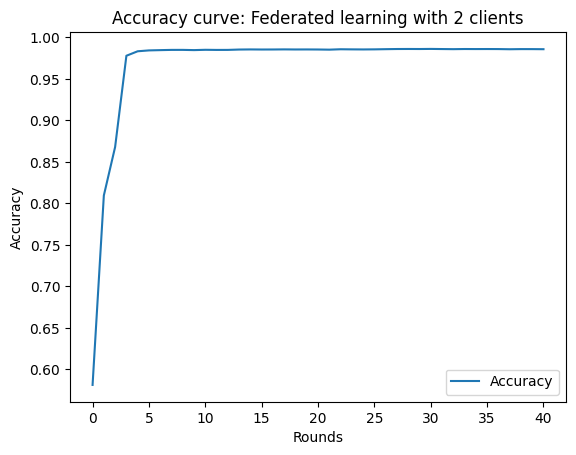

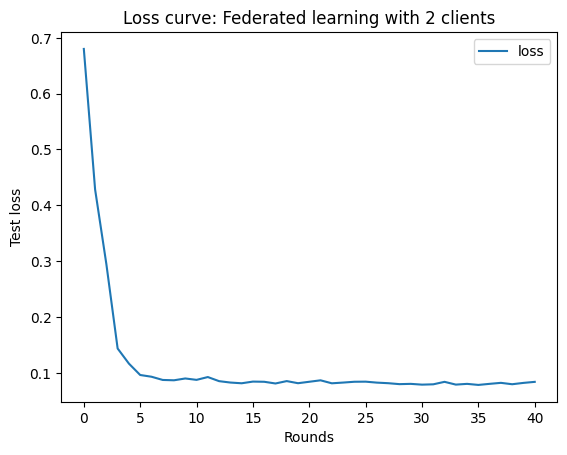

In [ ]:
figures(acc_values, loss_values)

In [ ]:
import pickle

with open('history2.pkl', 'wb') as f:
  pickle.dump(history, f)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Working with 3 clients
- Client1 has 246952 samples
- Client2 has 665248 samples
- Client3 has 206043 samples


In [ ]:
# Start simulation
history1 = fl.simulation.start_simulation(
    client_fn=client_fnc,
    num_clients=num_clients,
    config=fl.server.ServerConfig(num_rounds=40),
    strategy=strategy,
    client_resources={"num_cpus": 1, "num_gpus": 0},
    ray_init_args={
        "num_cpus": 1,
        "num_gpus": 0,
        "_system_config": {"automatic_object_spilling_enabled": False},
    },
)

INFO :      Starting Flower simulation, config: num_rounds=40, no round_timeout
INFO:flwr:Starting Flower simulation, config: num_rounds=40, no round_timeout
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-05-28 13:56:17,312	INFO worker.py:1621 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 1.0, 'memory': 7700125287.0, 'object_store_memory': 3850062643.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'CPU': 1.0, 'memory': 7700125287.0, 'object_store_memory': 3850062643.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO:flwr:Optimize your simulation with Flow

1840/1840 [==============================] - 2s 1ms/step


INFO :      initial parameters (loss, other metrics): 0.6877020597457886, {'loss': 0.6877020597457886, 'accuracy': 0.581292986869812, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.58129   1.00000   0.73521     34212\n           1    0.00000   0.00000   0.00000     24643\n\n    accuracy                        0.58129     58855\n   macro avg    0.29065   0.50000   0.36761     58855\nweighted avg    0.33790   0.58129   0.42737     58855\n'}
INFO:flwr:initial parameters (loss, other metrics): 0.6877020597457886, {'loss': 0.6877020597457886, 'accuracy': 0.581292986869812, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.58129   1.00000   0.73521     34212\n           1    0.00000   0.00000   0.00000     24643\n\n    accuracy                        0.58129     58855\n   macro avg    0.29065   0.50000   0.36761     58855\nweighted avg    0.33790   0.58129   0.42737     58855\n'}
INFO :      
I

1840/1840 [==============================] - 3s 2ms/step


INFO :      fit progress: (1, 1.0805416107177734, {'loss': 1.0805416107177734, 'accuracy': 0.581292986869812, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.58129   1.00000   0.73521     34212\n           1    0.00000   0.00000   0.00000     24643\n\n    accuracy                        0.58129     58855\n   macro avg    0.29065   0.50000   0.36761     58855\nweighted avg    0.33790   0.58129   0.42737     58855\n'}, 25.23135594700034)
INFO:flwr:fit progress: (1, 1.0805416107177734, {'loss': 1.0805416107177734, 'accuracy': 0.581292986869812, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.58129   1.00000   0.73521     34212\n           1    0.00000   0.00000   0.00000     24643\n\n    accuracy                        0.58129     58855\n   macro avg    0.29065   0.50000   0.36761     58855\nweighted avg    0.33790   0.58129   0.42737     58855\n'}, 25.23135594700034)
INFO :      configure_

1840/1840 [==============================] - 3s 1ms/step


INFO :      fit progress: (2, 1.3377755880355835, {'loss': 1.3377755880355835, 'accuracy': 0.5828052163124084, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.58240   0.99760   0.73545     34212\n           1    0.67589   0.00694   0.01374     24643\n\n    accuracy                        0.58281     58855\n   macro avg    0.62915   0.50227   0.37459     58855\nweighted avg    0.62155   0.58281   0.43326     58855\n'}, 69.9593242789997)
INFO:flwr:fit progress: (2, 1.3377755880355835, {'loss': 1.3377755880355835, 'accuracy': 0.5828052163124084, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.58240   0.99760   0.73545     34212\n           1    0.67589   0.00694   0.01374     24643\n\n    accuracy                        0.58281     58855\n   macro avg    0.62915   0.50227   0.37459     58855\nweighted avg    0.62155   0.58281   0.43326     58855\n'}, 69.9593242789997)
INFO :      configure_

1840/1840 [==============================] - 3s 1ms/step


INFO :      fit progress: (3, 1.9856294393539429, {'loss': 1.9856294393539429, 'accuracy': 0.5860674381256104, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.58409   0.99994   0.73743     34212\n           1    0.99298   0.01148   0.02271     24643\n\n    accuracy                        0.58607     58855\n   macro avg    0.78853   0.50571   0.38007     58855\nweighted avg    0.75529   0.58607   0.43817     58855\n'}, 112.45678644899999)
INFO:flwr:fit progress: (3, 1.9856294393539429, {'loss': 1.9856294393539429, 'accuracy': 0.5860674381256104, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.58409   0.99994   0.73743     34212\n           1    0.99298   0.01148   0.02271     24643\n\n    accuracy                        0.58607     58855\n   macro avg    0.78853   0.50571   0.38007     58855\nweighted avg    0.75529   0.58607   0.43817     58855\n'}, 112.45678644899999)
INFO :      config

1840/1840 [==============================] - 3s 1ms/step


INFO :      fit progress: (4, 3.210578441619873, {'loss': 3.210578441619873, 'accuracy': 0.5865601897239685, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.58438   0.99994   0.73766     34212\n           1    0.99363   0.01266   0.02500     24643\n\n    accuracy                        0.58656     58855\n   macro avg    0.78900   0.50630   0.38133     58855\nweighted avg    0.75573   0.58656   0.43926     58855\n'}, 153.75358986799984)
INFO:flwr:fit progress: (4, 3.210578441619873, {'loss': 3.210578441619873, 'accuracy': 0.5865601897239685, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.58438   0.99994   0.73766     34212\n           1    0.99363   0.01266   0.02500     24643\n\n    accuracy                        0.58656     58855\n   macro avg    0.78900   0.50630   0.38133     58855\nweighted avg    0.75573   0.58656   0.43926     58855\n'}, 153.75358986799984)
INFO :      configure_

1840/1840 [==============================] - 3s 1ms/step


INFO :      fit progress: (5, 3.777785539627075, {'loss': 3.777785539627075, 'accuracy': 0.5816668272018433, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.58152   0.99985   0.73536     34212\n           1    0.84375   0.00110   0.00219     24643\n\n    accuracy                        0.58167     58855\n   macro avg    0.71264   0.50047   0.36877     58855\nweighted avg    0.69132   0.58167   0.42837     58855\n'}, 197.19006951399933)
INFO:flwr:fit progress: (5, 3.777785539627075, {'loss': 3.777785539627075, 'accuracy': 0.5816668272018433, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.58152   0.99985   0.73536     34212\n           1    0.84375   0.00110   0.00219     24643\n\n    accuracy                        0.58167     58855\n   macro avg    0.71264   0.50047   0.36877     58855\nweighted avg    0.69132   0.58167   0.42837     58855\n'}, 197.19006951399933)
INFO :      configure_

1840/1840 [==============================] - 2s 1ms/step


INFO :      fit progress: (6, 4.772355556488037, {'loss': 4.772355556488037, 'accuracy': 0.5814968943595886, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.58142   0.99988   0.73528     34212\n           1    0.80000   0.00065   0.00130     24643\n\n    accuracy                        0.58150     58855\n   macro avg    0.69071   0.50027   0.36829     58855\nweighted avg    0.67294   0.58150   0.42796     58855\n'}, 239.30642735499896)
INFO:flwr:fit progress: (6, 4.772355556488037, {'loss': 4.772355556488037, 'accuracy': 0.5814968943595886, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.58142   0.99988   0.73528     34212\n           1    0.80000   0.00065   0.00130     24643\n\n    accuracy                        0.58150     58855\n   macro avg    0.69071   0.50027   0.36829     58855\nweighted avg    0.67294   0.58150   0.42796     58855\n'}, 239.30642735499896)
INFO :      configure_

1840/1840 [==============================] - 2s 1ms/step


INFO :      fit progress: (7, 5.546879291534424, {'loss': 5.546879291534424, 'accuracy': 0.5813949704170227, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.58136   0.99991   0.73524     34212\n           1    0.75000   0.00037   0.00073     24643\n\n    accuracy                        0.58139     58855\n   macro avg    0.66568   0.50014   0.36799     58855\nweighted avg    0.65197   0.58139   0.42770     58855\n'}, 279.0934297909989)
INFO:flwr:fit progress: (7, 5.546879291534424, {'loss': 5.546879291534424, 'accuracy': 0.5813949704170227, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.58136   0.99991   0.73524     34212\n           1    0.75000   0.00037   0.00073     24643\n\n    accuracy                        0.58139     58855\n   macro avg    0.66568   0.50014   0.36799     58855\nweighted avg    0.65197   0.58139   0.42770     58855\n'}, 279.0934297909989)
INFO :      configure_ev

1840/1840 [==============================] - 2s 1ms/step


INFO :      fit progress: (8, 5.283531665802002, {'loss': 5.283531665802002, 'accuracy': 0.5814289450645447, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.58138   0.99994   0.73526     34212\n           1    0.83333   0.00041   0.00081     24643\n\n    accuracy                        0.58143     58855\n   macro avg    0.70736   0.50017   0.36804     58855\nweighted avg    0.68687   0.58143   0.42774     58855\n'}, 320.84727251299955)
INFO:flwr:fit progress: (8, 5.283531665802002, {'loss': 5.283531665802002, 'accuracy': 0.5814289450645447, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.58138   0.99994   0.73526     34212\n           1    0.83333   0.00041   0.00081     24643\n\n    accuracy                        0.58143     58855\n   macro avg    0.70736   0.50017   0.36804     58855\nweighted avg    0.68687   0.58143   0.42774     58855\n'}, 320.84727251299955)
INFO :      configure_

1840/1840 [==============================] - 4s 2ms/step


INFO :      fit progress: (9, 4.395504951477051, {'loss': 4.395504951477051, 'accuracy': 0.5813440084457397, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.58133   0.99997   0.73523     34212\n           1    0.80000   0.00016   0.00032     24643\n\n    accuracy                        0.58134     58855\n   macro avg    0.69066   0.50007   0.36778     58855\nweighted avg    0.67289   0.58134   0.42752     58855\n'}, 360.8633816719994)
INFO:flwr:fit progress: (9, 4.395504951477051, {'loss': 4.395504951477051, 'accuracy': 0.5813440084457397, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.58133   0.99997   0.73523     34212\n           1    0.80000   0.00016   0.00032     24643\n\n    accuracy                        0.58134     58855\n   macro avg    0.69066   0.50007   0.36778     58855\nweighted avg    0.67289   0.58134   0.42752     58855\n'}, 360.8633816719994)
INFO :      configure_ev

1840/1840 [==============================] - 2s 1ms/step


INFO :      fit progress: (10, 3.779358386993408, {'loss': 3.779358386993408, 'accuracy': 0.5813440084457397, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.58133   0.99997   0.73523     34212\n           1    0.80000   0.00016   0.00032     24643\n\n    accuracy                        0.58134     58855\n   macro avg    0.69066   0.50007   0.36778     58855\nweighted avg    0.67289   0.58134   0.42752     58855\n'}, 397.42316102400036)
INFO:flwr:fit progress: (10, 3.779358386993408, {'loss': 3.779358386993408, 'accuracy': 0.5813440084457397, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.58133   0.99997   0.73523     34212\n           1    0.80000   0.00016   0.00032     24643\n\n    accuracy                        0.58134     58855\n   macro avg    0.69066   0.50007   0.36778     58855\nweighted avg    0.67289   0.58134   0.42752     58855\n'}, 397.42316102400036)
INFO :      configur

1840/1840 [==============================] - 3s 2ms/step


INFO :      fit progress: (11, 2.783571481704712, {'loss': 2.783571481704712, 'accuracy': 0.6819811463356018, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.64638   0.99997   0.78521     34212\n           1    0.99983   0.24051   0.38775     24643\n\n    accuracy                        0.68198     58855\n   macro avg    0.82311   0.62024   0.58648     58855\nweighted avg    0.79437   0.68198   0.61879     58855\n'}, 435.39329092499975)
INFO:flwr:fit progress: (11, 2.783571481704712, {'loss': 2.783571481704712, 'accuracy': 0.6819811463356018, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.64638   0.99997   0.78521     34212\n           1    0.99983   0.24051   0.38775     24643\n\n    accuracy                        0.68198     58855\n   macro avg    0.82311   0.62024   0.58648     58855\nweighted avg    0.79437   0.68198   0.61879     58855\n'}, 435.39329092499975)
INFO :      configur

1840/1840 [==============================] - 2s 1ms/step


INFO :      fit progress: (12, 3.290119171142578, {'loss': 3.290119171142578, 'accuracy': 0.5815478563308716, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.58146   0.99985   0.73530     34212\n           1    0.80000   0.00081   0.00162     24643\n\n    accuracy                        0.58155     58855\n   macro avg    0.69073   0.50033   0.36846     58855\nweighted avg    0.67296   0.58155   0.42811     58855\n'}, 477.9287751739994)
INFO:flwr:fit progress: (12, 3.290119171142578, {'loss': 3.290119171142578, 'accuracy': 0.5815478563308716, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.58146   0.99985   0.73530     34212\n           1    0.80000   0.00081   0.00162     24643\n\n    accuracy                        0.58155     58855\n   macro avg    0.69073   0.50033   0.36846     58855\nweighted avg    0.67296   0.58155   0.42811     58855\n'}, 477.9287751739994)
INFO :      configure_

1840/1840 [==============================] - 4s 2ms/step


INFO :      fit progress: (13, 2.9929730892181396, {'loss': 2.9929730892181396, 'accuracy': 0.6128621101379395, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.60026   0.99988   0.75017     34212\n           1    0.99786   0.07556   0.14048     24643\n\n    accuracy                        0.61286     58855\n   macro avg    0.79906   0.53772   0.44532     58855\nweighted avg    0.76673   0.61286   0.49489     58855\n'}, 517.7051592939988)
INFO:flwr:fit progress: (13, 2.9929730892181396, {'loss': 2.9929730892181396, 'accuracy': 0.6128621101379395, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.60026   0.99988   0.75017     34212\n           1    0.99786   0.07556   0.14048     24643\n\n    accuracy                        0.61286     58855\n   macro avg    0.79906   0.53772   0.44532     58855\nweighted avg    0.76673   0.61286   0.49489     58855\n'}, 517.7051592939988)
INFO :      config

1840/1840 [==============================] - 2s 1ms/step


INFO :      fit progress: (14, 2.9180285930633545, {'loss': 2.9180285930633545, 'accuracy': 0.6215614676475525, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.60572   0.99971   0.75437     34212\n           1    0.99582   0.09658   0.17608     24643\n\n    accuracy                        0.62156     58855\n   macro avg    0.80077   0.54814   0.46523     58855\nweighted avg    0.76906   0.62156   0.51224     58855\n'}, 557.7097942500004)
INFO:flwr:fit progress: (14, 2.9180285930633545, {'loss': 2.9180285930633545, 'accuracy': 0.6215614676475525, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.60572   0.99971   0.75437     34212\n           1    0.99582   0.09658   0.17608     24643\n\n    accuracy                        0.62156     58855\n   macro avg    0.80077   0.54814   0.46523     58855\nweighted avg    0.76906   0.62156   0.51224     58855\n'}, 557.7097942500004)
INFO :      config

1840/1840 [==============================] - 2s 1ms/step


INFO :      fit progress: (15, 3.4682540893554688, {'loss': 3.4682540893554688, 'accuracy': 0.5825333595275879, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.58203   0.99982   0.73576     34212\n           1    0.92941   0.00321   0.00639     24643\n\n    accuracy                        0.58253     58855\n   macro avg    0.75572   0.50152   0.37107     58855\nweighted avg    0.72748   0.58253   0.43036     58855\n'}, 602.861924286999)
INFO:flwr:fit progress: (15, 3.4682540893554688, {'loss': 3.4682540893554688, 'accuracy': 0.5825333595275879, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.58203   0.99982   0.73576     34212\n           1    0.92941   0.00321   0.00639     24643\n\n    accuracy                        0.58253     58855\n   macro avg    0.75572   0.50152   0.37107     58855\nweighted avg    0.72748   0.58253   0.43036     58855\n'}, 602.861924286999)
INFO :      configur

1840/1840 [==============================] - 4s 2ms/step


INFO :      fit progress: (16, 4.017650604248047, {'loss': 4.017650604248047, 'accuracy': 0.5817857384681702, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.58159   0.99988   0.73542     34212\n           1    0.89189   0.00134   0.00267     24643\n\n    accuracy                        0.58179     58855\n   macro avg    0.73674   0.50061   0.36905     58855\nweighted avg    0.71152   0.58179   0.42861     58855\n'}, 642.6957318699988)
INFO:flwr:fit progress: (16, 4.017650604248047, {'loss': 4.017650604248047, 'accuracy': 0.5817857384681702, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.58159   0.99988   0.73542     34212\n           1    0.89189   0.00134   0.00267     24643\n\n    accuracy                        0.58179     58855\n   macro avg    0.73674   0.50061   0.36905     58855\nweighted avg    0.71152   0.58179   0.42861     58855\n'}, 642.6957318699988)
INFO :      configure_

1840/1840 [==============================] - 2s 1ms/step


INFO :      fit progress: (17, 2.980299234390259, {'loss': 2.980299234390259, 'accuracy': 0.7129725813865662, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.66947   0.99991   0.80198     34212\n           1    0.99961   0.31461   0.47860     24643\n\n    accuracy                        0.71297     58855\n   macro avg    0.83454   0.65726   0.64029     58855\nweighted avg    0.80770   0.71297   0.66658     58855\n'}, 681.9267501569993)
INFO:flwr:fit progress: (17, 2.980299234390259, {'loss': 2.980299234390259, 'accuracy': 0.7129725813865662, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.66947   0.99991   0.80198     34212\n           1    0.99961   0.31461   0.47860     24643\n\n    accuracy                        0.71297     58855\n   macro avg    0.83454   0.65726   0.64029     58855\nweighted avg    0.80770   0.71297   0.66658     58855\n'}, 681.9267501569993)
INFO :      configure_

1840/1840 [==============================] - 4s 2ms/step


INFO :      fit progress: (18, 2.8760364055633545, {'loss': 2.8760364055633545, 'accuracy': 0.753088116645813, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.70190   0.99988   0.82481     34212\n           1    0.99960   0.41046   0.58196     24643\n\n    accuracy                        0.75309     58855\n   macro avg    0.85075   0.70517   0.70338     58855\nweighted avg    0.82655   0.75309   0.72312     58855\n'}, 721.4334555419991)
INFO:flwr:fit progress: (18, 2.8760364055633545, {'loss': 2.8760364055633545, 'accuracy': 0.753088116645813, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.70190   0.99988   0.82481     34212\n           1    0.99960   0.41046   0.58196     24643\n\n    accuracy                        0.75309     58855\n   macro avg    0.85075   0.70517   0.70338     58855\nweighted avg    0.82655   0.75309   0.72312     58855\n'}, 721.4334555419991)
INFO :      configur

1840/1840 [==============================] - 2s 1ms/step


INFO :      fit progress: (19, 3.098972797393799, {'loss': 3.098972797393799, 'accuracy': 0.7161158919334412, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.67188   0.99997   0.80374     34212\n           1    0.99987   0.32204   0.48717     24643\n\n    accuracy                        0.71612     58855\n   macro avg    0.83588   0.66100   0.64545     58855\nweighted avg    0.80922   0.71612   0.67119     58855\n'}, 758.4895779139988)
INFO:flwr:fit progress: (19, 3.098972797393799, {'loss': 3.098972797393799, 'accuracy': 0.7161158919334412, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.67188   0.99997   0.80374     34212\n           1    0.99987   0.32204   0.48717     24643\n\n    accuracy                        0.71612     58855\n   macro avg    0.83588   0.66100   0.64545     58855\nweighted avg    0.80922   0.71612   0.67119     58855\n'}, 758.4895779139988)
INFO :      configure_

1840/1840 [==============================] - 4s 2ms/step


INFO :      fit progress: (20, 3.1630172729492188, {'loss': 3.1630172729492188, 'accuracy': 0.7517628073692322, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.70077   0.99994   0.82404     34212\n           1    0.99980   0.40722   0.57872     24643\n\n    accuracy                        0.75176     58855\n   macro avg    0.85028   0.70358   0.70138     58855\nweighted avg    0.82597   0.75176   0.72132     58855\n'}, 798.7575180530002)
INFO:flwr:fit progress: (20, 3.1630172729492188, {'loss': 3.1630172729492188, 'accuracy': 0.7517628073692322, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.70077   0.99994   0.82404     34212\n           1    0.99980   0.40722   0.57872     24643\n\n    accuracy                        0.75176     58855\n   macro avg    0.85028   0.70358   0.70138     58855\nweighted avg    0.82597   0.75176   0.72132     58855\n'}, 798.7575180530002)
INFO :      config

1840/1840 [==============================] - 2s 1ms/step


INFO :      fit progress: (21, 3.0941660404205322, {'loss': 3.0941660404205322, 'accuracy': 0.7524254322052002, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.70132   0.99997   0.82443     34212\n           1    0.99990   0.40876   0.58029     24643\n\n    accuracy                        0.75243     58855\n   macro avg    0.85061   0.70436   0.70236     58855\nweighted avg    0.82634   0.75243   0.72221     58855\n'}, 838.4303186460002)
INFO:flwr:fit progress: (21, 3.0941660404205322, {'loss': 3.0941660404205322, 'accuracy': 0.7524254322052002, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.70132   0.99997   0.82443     34212\n           1    0.99990   0.40876   0.58029     24643\n\n    accuracy                        0.75243     58855\n   macro avg    0.85061   0.70436   0.70236     58855\nweighted avg    0.82634   0.75243   0.72221     58855\n'}, 838.4303186460002)
INFO :      config

1840/1840 [==============================] - 4s 2ms/step


INFO :      fit progress: (22, 3.5964930057525635, {'loss': 3.5964930057525635, 'accuracy': 0.7532410025596619, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.70202   0.99994   0.82490     34212\n           1    0.99980   0.41075   0.58228     24643\n\n    accuracy                        0.75324     58855\n   macro avg    0.85091   0.70534   0.70359     58855\nweighted avg    0.82670   0.75324   0.72331     58855\n'}, 877.8019851179997)
INFO:flwr:fit progress: (22, 3.5964930057525635, {'loss': 3.5964930057525635, 'accuracy': 0.7532410025596619, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.70202   0.99994   0.82490     34212\n           1    0.99980   0.41075   0.58228     24643\n\n    accuracy                        0.75324     58855\n   macro avg    0.85091   0.70534   0.70359     58855\nweighted avg    0.82670   0.75324   0.72331     58855\n'}, 877.8019851179997)
INFO :      config

1840/1840 [==============================] - 2s 1ms/step


INFO :      fit progress: (23, 3.897420883178711, {'loss': 3.897420883178711, 'accuracy': 0.7476339936256409, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.69729   0.99997   0.82164     34212\n           1    0.99990   0.39731   0.56867     24643\n\n    accuracy                        0.74763     58855\n   macro avg    0.84859   0.69864   0.69515     58855\nweighted avg    0.82399   0.74763   0.71572     58855\n'}, 914.9676821470002)
INFO:flwr:fit progress: (23, 3.897420883178711, {'loss': 3.897420883178711, 'accuracy': 0.7476339936256409, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.69729   0.99997   0.82164     34212\n           1    0.99990   0.39731   0.56867     24643\n\n    accuracy                        0.74763     58855\n   macro avg    0.84859   0.69864   0.69515     58855\nweighted avg    0.82399   0.74763   0.71572     58855\n'}, 914.9676821470002)
INFO :      configure_

1840/1840 [==============================] - 2s 1ms/step


INFO :      fit progress: (24, 3.5684783458709717, {'loss': 3.5684783458709717, 'accuracy': 0.7533939480781555, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.70215   0.99994   0.82499     34212\n           1    0.99980   0.41111   0.58264     24643\n\n    accuracy                        0.75339     58855\n   macro avg    0.85097   0.70553   0.70382     58855\nweighted avg    0.82678   0.75339   0.72352     58855\n'}, 953.8631938449998)
INFO:flwr:fit progress: (24, 3.5684783458709717, {'loss': 3.5684783458709717, 'accuracy': 0.7533939480781555, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.70215   0.99994   0.82499     34212\n           1    0.99980   0.41111   0.58264     24643\n\n    accuracy                        0.75339     58855\n   macro avg    0.85097   0.70553   0.70382     58855\nweighted avg    0.82678   0.75339   0.72352     58855\n'}, 953.8631938449998)
INFO :      config

1840/1840 [==============================] - 2s 1ms/step


INFO :      fit progress: (25, 4.005202293395996, {'loss': 4.005202293395996, 'accuracy': 0.7130405306816101, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.66950   1.00000   0.80203     34212\n           1    1.00000   0.31465   0.47869     24643\n\n    accuracy                        0.71304     58855\n   macro avg    0.83475   0.65733   0.64036     58855\nweighted avg    0.80788   0.71304   0.66665     58855\n'}, 994.7654303500003)
INFO:flwr:fit progress: (25, 4.005202293395996, {'loss': 4.005202293395996, 'accuracy': 0.7130405306816101, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.66950   1.00000   0.80203     34212\n           1    1.00000   0.31465   0.47869     24643\n\n    accuracy                        0.71304     58855\n   macro avg    0.83475   0.65733   0.64036     58855\nweighted avg    0.80788   0.71304   0.66665     58855\n'}, 994.7654303500003)
INFO :      configure_

1840/1840 [==============================] - 2s 1ms/step


INFO :      fit progress: (26, 3.8957178592681885, {'loss': 3.8957178592681885, 'accuracy': 0.7492651343345642, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.69866   0.99994   0.82258     34212\n           1    0.99980   0.40125   0.57267     24643\n\n    accuracy                        0.74927     58855\n   macro avg    0.84923   0.70060   0.69763     58855\nweighted avg    0.82475   0.74927   0.71794     58855\n'}, 1036.0286056699988)
INFO:flwr:fit progress: (26, 3.8957178592681885, {'loss': 3.8957178592681885, 'accuracy': 0.7492651343345642, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.69866   0.99994   0.82258     34212\n           1    0.99980   0.40125   0.57267     24643\n\n    accuracy                        0.74927     58855\n   macro avg    0.84923   0.70060   0.69763     58855\nweighted avg    0.82475   0.74927   0.71794     58855\n'}, 1036.0286056699988)
INFO :      conf

1840/1840 [==============================] - 2s 1ms/step


INFO :      fit progress: (27, 3.9772069454193115, {'loss': 3.9772069454193115, 'accuracy': 0.7477359771728516, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.69737   0.99997   0.82170     34212\n           1    0.99990   0.39756   0.56891     24643\n\n    accuracy                        0.74774     58855\n   macro avg    0.84864   0.69876   0.69531     58855\nweighted avg    0.82404   0.74774   0.71586     58855\n'}, 1075.6938642200003)
INFO:flwr:fit progress: (27, 3.9772069454193115, {'loss': 3.9772069454193115, 'accuracy': 0.7477359771728516, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.69737   0.99997   0.82170     34212\n           1    0.99990   0.39756   0.56891     24643\n\n    accuracy                        0.74774     58855\n   macro avg    0.84864   0.69876   0.69531     58855\nweighted avg    0.82404   0.74774   0.71586     58855\n'}, 1075.6938642200003)
INFO :      conf

1840/1840 [==============================] - 2s 1ms/step


INFO :      fit progress: (28, 7.195013523101807, {'loss': 7.195013523101807, 'accuracy': 0.5816498398780823, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.58150   0.99997   0.73537     34212\n           1    0.95652   0.00089   0.00178     24643\n\n    accuracy                        0.58165     58855\n   macro avg    0.76901   0.50043   0.36858     58855\nweighted avg    0.73853   0.58165   0.42821     58855\n'}, 1115.0646292740003)
INFO:flwr:fit progress: (28, 7.195013523101807, {'loss': 7.195013523101807, 'accuracy': 0.5816498398780823, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.58150   0.99997   0.73537     34212\n           1    0.95652   0.00089   0.00178     24643\n\n    accuracy                        0.58165     58855\n   macro avg    0.76901   0.50043   0.36858     58855\nweighted avg    0.73853   0.58165   0.42821     58855\n'}, 1115.0646292740003)
INFO :      configur

1840/1840 [==============================] - 2s 1ms/step


INFO :      fit progress: (29, 4.914876461029053, {'loss': 4.914876461029053, 'accuracy': 0.5836547613143921, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.58269   0.99982   0.73628     34212\n           1    0.96026   0.00588   0.01170     24643\n\n    accuracy                        0.58365     58855\n   macro avg    0.77148   0.50285   0.37399     58855\nweighted avg    0.74078   0.58365   0.43289     58855\n'}, 1153.9140668349992)
INFO:flwr:fit progress: (29, 4.914876461029053, {'loss': 4.914876461029053, 'accuracy': 0.5836547613143921, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.58269   0.99982   0.73628     34212\n           1    0.96026   0.00588   0.01170     24643\n\n    accuracy                        0.58365     58855\n   macro avg    0.77148   0.50285   0.37399     58855\nweighted avg    0.74078   0.58365   0.43289     58855\n'}, 1153.9140668349992)
INFO :      configur

1840/1840 [==============================] - 2s 1ms/step


INFO :      fit progress: (30, 3.9914562702178955, {'loss': 3.9914562702178955, 'accuracy': 0.7518307566642761, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.70091   0.99965   0.82404     34212\n           1    0.99881   0.40778   0.57913     24643\n\n    accuracy                        0.75183     58855\n   macro avg    0.84986   0.70372   0.70158     58855\nweighted avg    0.82564   0.75183   0.72149     58855\n'}, 1194.3081553069987)
INFO:flwr:fit progress: (30, 3.9914562702178955, {'loss': 3.9914562702178955, 'accuracy': 0.7518307566642761, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.70091   0.99965   0.82404     34212\n           1    0.99881   0.40778   0.57913     24643\n\n    accuracy                        0.75183     58855\n   macro avg    0.84986   0.70372   0.70158     58855\nweighted avg    0.82564   0.75183   0.72149     58855\n'}, 1194.3081553069987)
INFO :      conf

1840/1840 [==============================] - 4s 2ms/step


INFO :      fit progress: (31, 4.308719635009766, {'loss': 4.308719635009766, 'accuracy': 0.7133803367614746, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.66982   0.99974   0.80218     34212\n           1    0.99884   0.31583   0.47991     24643\n\n    accuracy                        0.71338     58855\n   macro avg    0.83433   0.65778   0.64105     58855\nweighted avg    0.80758   0.71338   0.66725     58855\n'}, 1234.200241691)
INFO:flwr:fit progress: (31, 4.308719635009766, {'loss': 4.308719635009766, 'accuracy': 0.7133803367614746, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.66982   0.99974   0.80218     34212\n           1    0.99884   0.31583   0.47991     24643\n\n    accuracy                        0.71338     58855\n   macro avg    0.83433   0.65778   0.64105     58855\nweighted avg    0.80758   0.71338   0.66725     58855\n'}, 1234.200241691)
INFO :      configure_evalua

1840/1840 [==============================] - 2s 1ms/step


INFO :      fit progress: (32, 4.174858570098877, {'loss': 4.174858570098877, 'accuracy': 0.7518307566642761, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.70090   0.99968   0.82404     34212\n           1    0.99891   0.40774   0.57910     24643\n\n    accuracy                        0.75183     58855\n   macro avg    0.84990   0.70371   0.70157     58855\nweighted avg    0.82568   0.75183   0.72148     58855\n'}, 1273.517787232)
INFO:flwr:fit progress: (32, 4.174858570098877, {'loss': 4.174858570098877, 'accuracy': 0.7518307566642761, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.70090   0.99968   0.82404     34212\n           1    0.99891   0.40774   0.57910     24643\n\n    accuracy                        0.75183     58855\n   macro avg    0.84990   0.70371   0.70157     58855\nweighted avg    0.82568   0.75183   0.72148     58855\n'}, 1273.517787232)
INFO :      configure_evalua

1840/1840 [==============================] - 3s 2ms/step


INFO :      fit progress: (33, 4.8892645835876465, {'loss': 4.8892645835876465, 'accuracy': 0.6251805424690247, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.60802   0.99968   0.75614     34212\n           1    0.99578   0.10526   0.19040     24643\n\n    accuracy                        0.62518     58855\n   macro avg    0.80190   0.55247   0.47327     58855\nweighted avg    0.77038   0.62518   0.51926     58855\n'}, 1312.870057787999)
INFO:flwr:fit progress: (33, 4.8892645835876465, {'loss': 4.8892645835876465, 'accuracy': 0.6251805424690247, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.60802   0.99968   0.75614     34212\n           1    0.99578   0.10526   0.19040     24643\n\n    accuracy                        0.62518     58855\n   macro avg    0.80190   0.55247   0.47327     58855\nweighted avg    0.77038   0.62518   0.51926     58855\n'}, 1312.870057787999)
INFO :      config

1840/1840 [==============================] - 2s 1ms/step


INFO :      fit progress: (34, 8.83513355255127, {'loss': 8.83513355255127, 'accuracy': 0.5818197131156921, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.58161   0.99991   0.73544     34212\n           1    0.91892   0.00138   0.00276     24643\n\n    accuracy                        0.58182     58855\n   macro avg    0.75026   0.50065   0.36910     58855\nweighted avg    0.72284   0.58182   0.42866     58855\n'}, 1351.910846416)
INFO:flwr:fit progress: (34, 8.83513355255127, {'loss': 8.83513355255127, 'accuracy': 0.5818197131156921, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.58161   0.99991   0.73544     34212\n           1    0.91892   0.00138   0.00276     24643\n\n    accuracy                        0.58182     58855\n   macro avg    0.75026   0.50065   0.36910     58855\nweighted avg    0.72284   0.58182   0.42866     58855\n'}, 1351.910846416)
INFO :      configure_evaluate: 

1840/1840 [==============================] - 3s 2ms/step


INFO :      fit progress: (35, 13.256979942321777, {'loss': 13.256979942321777, 'accuracy': 0.5818367004394531, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.58162   0.99985   0.73544     34212\n           1    0.88095   0.00150   0.00300     24643\n\n    accuracy                        0.58184     58855\n   macro avg    0.73129   0.50068   0.36922     58855\nweighted avg    0.70695   0.58184   0.42876     58855\n'}, 1390.5232364780004)
INFO:flwr:fit progress: (35, 13.256979942321777, {'loss': 13.256979942321777, 'accuracy': 0.5818367004394531, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.58162   0.99985   0.73544     34212\n           1    0.88095   0.00150   0.00300     24643\n\n    accuracy                        0.58184     58855\n   macro avg    0.73129   0.50068   0.36922     58855\nweighted avg    0.70695   0.58184   0.42876     58855\n'}, 1390.5232364780004)
INFO :      conf

1840/1840 [==============================] - 2s 1ms/step


INFO :      fit progress: (36, 11.584677696228027, {'loss': 11.584677696228027, 'accuracy': 0.5818027257919312, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.58160   0.99991   0.73543     34212\n           1    0.91667   0.00134   0.00267     24643\n\n    accuracy                        0.58180     58855\n   macro avg    0.74913   0.50063   0.36905     58855\nweighted avg    0.72189   0.58180   0.42862     58855\n'}, 1427.4379711210004)
INFO:flwr:fit progress: (36, 11.584677696228027, {'loss': 11.584677696228027, 'accuracy': 0.5818027257919312, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.58160   0.99991   0.73543     34212\n           1    0.91667   0.00134   0.00267     24643\n\n    accuracy                        0.58180     58855\n   macro avg    0.74913   0.50063   0.36905     58855\nweighted avg    0.72189   0.58180   0.42862     58855\n'}, 1427.4379711210004)
INFO :      conf

1840/1840 [==============================] - 4s 2ms/step


INFO :      fit progress: (37, 8.291504859924316, {'loss': 8.291504859924316, 'accuracy': 0.5820915699005127, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.58177   0.99985   0.73556     34212\n           1    0.91228   0.00211   0.00421     24643\n\n    accuracy                        0.58209     58855\n   macro avg    0.74703   0.50098   0.36988     58855\nweighted avg    0.72016   0.58209   0.42934     58855\n'}, 1469.3592179019997)
INFO:flwr:fit progress: (37, 8.291504859924316, {'loss': 8.291504859924316, 'accuracy': 0.5820915699005127, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.58177   0.99985   0.73556     34212\n           1    0.91228   0.00211   0.00421     24643\n\n    accuracy                        0.58209     58855\n   macro avg    0.74703   0.50098   0.36988     58855\nweighted avg    0.72016   0.58209   0.42934     58855\n'}, 1469.3592179019997)
INFO :      configur

1840/1840 [==============================] - 4s 2ms/step


INFO :      fit progress: (38, 6.53114128112793, {'loss': 6.53114128112793, 'accuracy': 0.5819726586341858, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.58170   0.99985   0.73550     34212\n           1    0.90000   0.00183   0.00364     24643\n\n    accuracy                        0.58197     58855\n   macro avg    0.74085   0.50084   0.36957     58855\nweighted avg    0.71498   0.58197   0.42907     58855\n'}, 1508.6214420319993)
INFO:flwr:fit progress: (38, 6.53114128112793, {'loss': 6.53114128112793, 'accuracy': 0.5819726586341858, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.58170   0.99985   0.73550     34212\n           1    0.90000   0.00183   0.00364     24643\n\n    accuracy                        0.58197     58855\n   macro avg    0.74085   0.50084   0.36957     58855\nweighted avg    0.71498   0.58197   0.42907     58855\n'}, 1508.6214420319993)
INFO :      configure_ev

1840/1840 [==============================] - 4s 2ms/step


INFO :      fit progress: (39, 6.110650539398193, {'loss': 6.110650539398193, 'accuracy': 0.5818027257919312, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.58160   0.99985   0.73542     34212\n           1    0.87500   0.00142   0.00284     24643\n\n    accuracy                        0.58180     58855\n   macro avg    0.72830   0.50064   0.36913     58855\nweighted avg    0.70445   0.58180   0.42868     58855\n'}, 1548.146115828)
INFO:flwr:fit progress: (39, 6.110650539398193, {'loss': 6.110650539398193, 'accuracy': 0.5818027257919312, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.58160   0.99985   0.73542     34212\n           1    0.87500   0.00142   0.00284     24643\n\n    accuracy                        0.58180     58855\n   macro avg    0.72830   0.50064   0.36913     58855\nweighted avg    0.70445   0.58180   0.42868     58855\n'}, 1548.146115828)
INFO :      configure_evalua

1840/1840 [==============================] - 2s 1ms/step


INFO :      fit progress: (40, 6.4915337562561035, {'loss': 6.4915337562561035, 'accuracy': 0.5817857384681702, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.58159   0.99985   0.73541     34212\n           1    0.87179   0.00138   0.00276     24643\n\n    accuracy                        0.58179     58855\n   macro avg    0.72669   0.50062   0.36908     58855\nweighted avg    0.70310   0.58179   0.42864     58855\n'}, 1585.1477096050003)
INFO:flwr:fit progress: (40, 6.4915337562561035, {'loss': 6.4915337562561035, 'accuracy': 0.5817857384681702, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.58159   0.99985   0.73541     34212\n           1    0.87179   0.00138   0.00276     24643\n\n    accuracy                        0.58179     58855\n   macro avg    0.72669   0.50062   0.36908     58855\nweighted avg    0.70310   0.58179   0.42864     58855\n'}, 1585.1477096050003)
INFO :      conf

In [ ]:
var = history1.metrics_centralized['Centralised report']

metrics(var)

In [ ]:
accuracy = history1.metrics_centralized['accuracy']
acc_values = [item[1] for item in accuracy]
loss = history.metrics_centralized['loss']
loss_values = [item[1] for item in loss]

figures(acc_values, loss_values)


In [ ]:
import pickle

with open('history3.pkl', 'wb') as f:
  pickle.dump(history1, f)


## Working 4 Clients


In [ ]:
# Start simulation
history2 = fl.simulation.start_simulation(
    client_fn=client_fnc,
    num_clients=num_clients,
    config=fl.server.ServerConfig(num_rounds=40),
    strategy=strategy,
    client_resources={"num_cpus": 1, "num_gpus": 0},
    ray_init_args={
        "num_cpus": 1,
        "num_gpus": 0,
        "_system_config": {"automatic_object_spilling_enabled": False},
    },
)

In [ ]:
var = history2.metrics_centralized['Centralised report']

metrics(var)

In [ ]:
accuracy = history2.metrics_centralized['accuracy']
acc_values = [item[1] for item in accuracy]
loss = history.metrics_centralized['loss']
loss_values = [item[1] for item in loss]

figures(acc_values, loss_values)

In [ ]:
import pickle

with open('history4.pkl', 'wb') as f:
  pickle.dump(history2, f)

## Working with 5 Clients


In [ ]:
# Start simulation
history3 = fl.simulation.start_simulation(
    client_fn=client_fnc,
    num_clients=num_clients,
    config=fl.server.ServerConfig(num_rounds=40),
    strategy=strategy,
    client_resources={"num_cpus": 1, "num_gpus": 0},
    ray_init_args={
        "num_cpus": 1,
        "num_gpus": 0,
        "_system_config": {"automatic_object_spilling_enabled": False},
    },
)

In [ ]:
var = history3.metrics_centralized['Centralised report']

metrics(var)

In [ ]:
accuracy = history3.metrics_centralized['accuracy']
acc_values = [item[1] for item in accuracy]
loss = history.metrics_centralized['loss']
loss_values = [item[1] for item in loss]

figures(acc_values, loss_values)

In [ ]:
import pickle

with open('history5.pkl', 'wb') as f:
  pickle.dump(history3, f)

# Working with 6 Client

In [ ]:
# Start simulation
history4 = fl.simulation.start_simulation(
    client_fn=client_fnc,
    num_clients=num_clients,
    config=fl.server.ServerConfig(num_rounds=40),
    strategy=strategy,
    client_resources={"num_cpus": 1, "num_gpus": 0},
    ray_init_args={
        "num_cpus": 1,
        "num_gpus": 0,
        "_system_config": {"automatic_object_spilling_enabled": False},
    },
)

In [ ]:
var = history4.metrics_centralized['Centralised report']

metrics(var)

In [ ]:
accuracy = history4.metrics_centralized['accuracy']
acc_values = [item[1] for item in accuracy]
loss = history.metrics_centralized['loss']
loss_values = [item[1] for item in loss]

figures(acc_values, loss_values)

In [ ]:
import pickle

with open('history6.pkl', 'wb') as f:
  pickle.dump(history4, f)